In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split

import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal, MultivariateNormal
from torch.distributions import kl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model will be trained on {device}.")
EPS = 1e-6  # for numerical stability control

The model will be trained on cpu.


## Introduction to Neural Networks

### What are Neural Networks?

Neural Networks (NNs) are a class of machine learning models inspired by the structure and function of the human brain. They consist of interconnected nodes (neurons) organized in layers, designed to recognize patterns in data and make decisions or predictions based on those patterns.

#### Why Use Neural Networks?

Neural networks are quite an old method now but have found large popularity. They are quite versatile, easy to conceptualise, and show remarkable ability in a wid range of tasks from classification to dimension reduction. Neural networks have the following advantages going for them:

1. **Handling complex, non-linear relationships**: Neural networks can model intricate, non-linear relationships in data, making them suitable for a wide range of real-world problems.

2. **Automatic feature extraction**: Deep neural networks can automatically learn relevant features from raw data, reducing the need for manual feature engineering.

3. **Scalability**: Neural networks can handle large amounts of data and scale well with increasing data sizes and computational resources.

4. **Versatility**: They can be applied to various tasks such as classification, regression, clustering, and dimensionality reduction.

5. **Continuous learning**: Neural networks can be updated with new data, allowing them to adapt to changing environments.

#### Applications of Neural Networks

Neural networks have found applications in numerous fields, including:

- **Computer Vision**: Image classification, object detection, facial recognition
- **Game Playing**: Developing AI that can play complex games like Go
- **Autonomous Vehicles**: Processing sensor data for navigation and decision making

#### Basic Structure of a Neural Network

A typical neural network consists of:

1. **Input Layer**: Receives the initial data
2. **Hidden Layers**: Process the data through weighted connections
3. **Output Layer**: Produces the final prediction or decision

Each neuron in these layers applies an activation function to its inputs, introducing non-linearity into the model. We will now look at a simple example usage of neural networks for the problem of classification. Before this however, you may want to check out the following online resource for an [interactive demonstration of a neural network](https://playground.tensorflow.org/).



### The Moons Dataset

The "moons" dataset is a popular toy dataset, often used for binary classification tasks. It's called the moons dataset because it creates two interleaving half circles when plotted, resembling two crescent moons.

Key characteristics of the moons dataset:

1. It's a 2D dataset, meaning each sample has two features (x & y coordinates).
2. It has two classes, typically labeled as 0 and 1 representing which of the two moons a point belongs to.
3. The classes are not linearly separable, making it a good test for the non-linear capabilities of neural networks.
4. We can control the amount of noise added to the data, which affects how cleanly the two classes can be separated.

This dataset is particularly useful for visualizing the decision boundary of a classifier, as we can easily plot the data and the model's predictions in a 2D space.

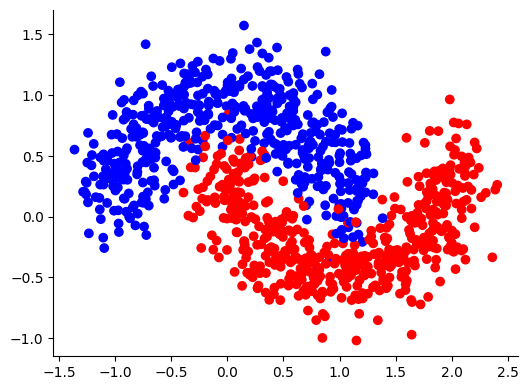

In [ ]:
# Generate the moons dataset
X, Y = datasets.make_moons(1000, noise=0.20, random_state=6)

# Plot the dataset
plt.figure(figsize=(6, 4.5))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="bwr")
sns.despine()
plt.show()

We can see above the two classes (blue and red), and each sample point that forms our two moons. We can also see the non-linear boundary as well as some overlap between the classes.

#### Test & Training Split

We define the test size to be 25% of the total data set and use the 75% remaining for training. This should

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=45)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.get_default_dtype())
X_test = torch.tensor(X_test, dtype=torch.get_default_dtype())
y_train = torch.tensor(y_train, dtype=torch.get_default_dtype()).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.get_default_dtype()).view(-1, 1)

# Set the meshgrid
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#### Constructing a NN

Now we create the conventional NN using PyTorch- a very common library for machine learning in Python. We start with 2 inputs, go through a series of layers, and output a single value.

In [ ]:
class ConventionalNN(nn.Module):
    def __init__(self, features):
        super(ConventionalNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return self.sigmoid(X)

    def loss_fn(self, X, y, reg_lambda=0., reg_ord=2):
        y_pred = self.forward(X)
        loss = F.binary_cross_entropy(y_pred, y)
        if reg_lambda == 0.:
            return loss
        else:  # We can add a regularizer here to penalize large weights.
            reg_term = sum(torch.linalg.vector_norm(param, ord=reg_ord) ** reg_ord for param in self.parameters())
            return loss + reg_lambda / y.shape[0] * reg_term

    @torch.no_grad()
    def predict(self, X_test, y_test=None, batch_size=None, device=torch.device('cpu')):
        test_dataset = TensorDataset(X_test, y_test) if y_test is not None else TensorDataset(X_test)
        batch_size = len(test_dataset) if batch_size is None else batch_size
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.to(device)
        if y_test is not None:
            wrong = 0
            for x, y in test_dataloader:
                x, y = x.to(device), y.to(device)
                y_pred = self.forward(x)
                y_pred = (y_pred > 0.5).to(torch.get_default_dtype())
                wrong += (y_pred - y).abs().sum().item()
            return 1 - wrong / len(test_dataset)
        else:
            preds = []
            for x in test_dataloader:
                y_pred = self.forward(x[0].to(device))
                preds.append(y_pred)
            return torch.cat(preds, dim=-2).to(torch.device('cpu'))

# construct NN
# features = [2, 8, 16, 16, 8, 1]
features = [2, 8, 16, 1]

mlp = ConventionalNN(features)
mlp

ConventionalNN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

### Training our NN

Training is the heart of the machine learning process. It's where our neural network learns to make accurate predictions by adjusting its internal parameters (weights and biases) based on the input data. The training process involves several key concepts:

1. **Batching**: We divide our data into small batches to process at a time. This improves efficiency and helps the model generalize better.

2. **Forward Pass**: The input data is passed through the network, generating predictions.

3. **Loss Calculation**: We compare the model's predictions to the true labels using a loss function, which quantifies how far off our predictions are.

4. **Backpropagation**: The error is propagated backwards through the network, calculating how each parameter contributed to the error.

5. **Optimization**: An optimization algorithm (in this case, Adam) updates the model's parameters to minimize the loss.

6. **Epochs**: We repeat this process multiple times over the entire dataset, with each full pass called an epoch.

The `train` function encapsulates this entire process. It takes our model, data, and various hyperparameters as inputs, then iteratively improves the model's performance. By the end of training, our neural network should be able to accurately classify the moon dataset.

Epoch [50/1000], Loss: 0.2571
Epoch [100/1000], Loss: 0.0989
Epoch [150/1000], Loss: 0.0610
Epoch [200/1000], Loss: 0.0580
Epoch [250/1000], Loss: 0.0565
Epoch [300/1000], Loss: 0.0558
Epoch [350/1000], Loss: 0.0554
Epoch [400/1000], Loss: 0.0542
Epoch [450/1000], Loss: 0.0536
Epoch [500/1000], Loss: 0.0533
Epoch [550/1000], Loss: 0.0529
Epoch [600/1000], Loss: 0.0527
Epoch [650/1000], Loss: 0.0525
Epoch [700/1000], Loss: 0.0524
Epoch [750/1000], Loss: 0.0520
Epoch [800/1000], Loss: 0.0518
Epoch [850/1000], Loss: 0.0516
Epoch [900/1000], Loss: 0.0515
Epoch [950/1000], Loss: 0.0514
Epoch [1000/1000], Loss: 0.0512


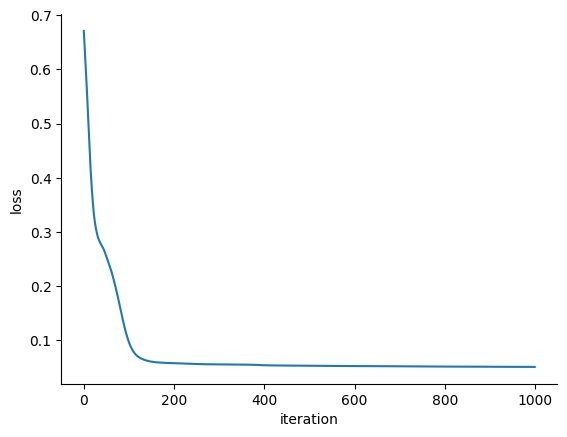

In [ ]:
def train(
        model, X, y, batch_size=32, lr=0.01, reg_lambda=0., reg_ord=2,
        epochs=10, print_iters=50, device=torch.device('cpu')
):
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoader for batching
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()  # Set model to training mode
    model.to(device)

    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()                 # Zero the gradient
            loss = model.loss_fn(
                inputs, labels, reg_lambda, reg_ord
            )                                     # Loss function (CrossEntropyLoss in this case)
            loss.backward()                       # Backpropagation
            optimizer.step()                      # Update weights
            losses.append(loss.item())

        if (epoch + 1) % print_iters == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, losses

mlp, loss_list = train(mlp, X_train, y_train, batch_size=y_train.size(-2), lr=0.01, epochs=1000, device=device)

plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
sns.despine()

We see above how our model improves through iterations via a decreased loss value.

### Model Performance

We need ways to compare our models performance to other models (or potentially to different parameters in our model). A very simple measure is accuracy as shown below:

In [ ]:
mlp.eval()
acc = mlp.predict(X_test, y_test, device=device)

print(f"The accuracy on the test data is {acc * 100:.2f}%")

The accuracy on the test data is 95.20%


However, we've essentially just compressed all of our model and its learning into a single value. Sometimes to properly compare models and their predictions we want a bit more information than just accuracy. For this, we could consider decision boundaries.

A decision boundary is the region of a problem space where a machine learning model switches from predicting one class to another. In other words, it's the line that separates different classes in the feature space.

Key points about decision boundaries:

1. **Shape**: For linear models, the decision boundary is always a straight line. For non-linear models like neural networks, decision boundaries can be curved and complex.

2. **Interpretation**: Points on one side of the boundary are classified as one class, while points on the other side are classified as the other class.

3. **Model Complexity**: The complexity of the decision boundary often reflects the complexity of the model. Simple models produce simple boundaries, while more complex models can create more intricate boundaries capturing more complex relationships.

4. **Overfitting**: Very complex decision boundaries that closely fit the training data might indicate overfitting, where the model learns the noise in the training data too well and may not generalize to new data.

5. **Visualization**: For 2D datasets like our moons dataset, we can visualize the decision boundary by creating a grid of points, having our model predict the class for each point, and then plotting these predictions.

Below we show how to plot a decision boundary for our binary classification on the two moons dataset using our implemented NN.

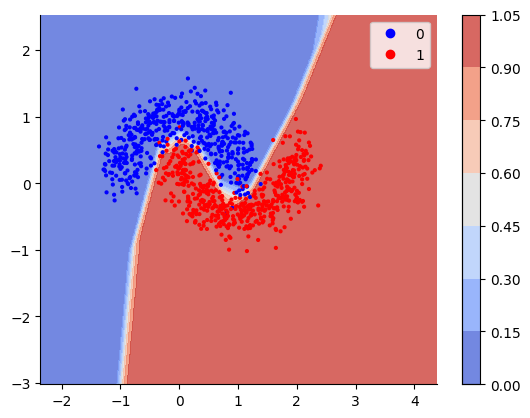

In [ ]:
def plot_binary_class(X_scatters, y_scatters, xx1_grid, xx2_grid, grid_preds_mean, legend=False, color_bar=False):
    """
    Function to plot binary classification outputs.
    """
    fig, ax = plt.subplots(1, 1)

    CS = ax.contourf(xx1_grid, xx2_grid, grid_preds_mean, cmap="coolwarm", alpha=0.8)
    hs = ax.scatter(X_scatters[:, 0], X_scatters[:, 1], c=y_scatters, s=4, cmap="bwr")

    if legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_actual, labels_actual = hs.legend_elements()
        handles_actual.extend(handles)
        labels_actual.extend(labels)
        ax.legend(handles_actual, labels_actual)

    if color_bar:
        fig.colorbar(CS)

    sns.despine()


# Predict on grid
inputs = np.stack([xx.ravel(), yy.ravel()], axis=-1)
p = mlp.predict(torch.as_tensor(inputs, dtype=torch.get_default_dtype()), device=device)
p = p.reshape(xx.shape)

plot_binary_class(X, Y, xx, yy, p, legend=True, color_bar=True)

### Exercise: Exploring Neural Network Structures

In this exercise, we'll explore how changes in the neural network structure and training process affect its performance and decision boundaries. This will help you understand the impact of various hyperparameters and architectural choices.

#### 1. Changing the Hidden Layers

Start by modifying the number of hidden layers and the number of nodes in these layers. What happens if you make the NN really wide but shallow and vice versa? What if you have a really deep amount of layers? See which ways seem to improve the accuracy and the decision boundaries. Take our previous code and adapt it here to define a new NN model.

In [ ]:
#Your code here.

#### 2. Change the Activation Functions

We just use ReLu previously. What if we use different activation functions like ELU, TanH, or leakyRELU?

In [ ]:
#Code here

#### 3. Write an Activation Function

Can you find another example of an activation function online? Implement it below.

In [ ]:
#Code here

#### 4. Regularisation

We can use an L2 regulariser in our training. Can you find out how to add this L2 regulariser to our NN model and see what effect it has on accuracy, the loss graph, and the decision boundary?

In [ ]:
#Code here

### Models on Limited Data

What if we were in a situation where we did not have that much training data- how would our NN perform? You should experiment with different ratios of training/testing data below to see how it impacts the decision boundaries and accuracy of our model.

1. Try the initial split (75/25 training/testing)
2. Change the split in 25% steps
3. Now try and find the split where the model gets <50% accuracy

In [ ]:
#Add your code to see how the decision boundary and accuracy changes as the training data size changes

# Split the dataset into training and testing sets
X_smalltrain, X_bigtest, y_smalltrain, y_bigtest = train_test_split(X, Y, test_size=0.75, random_state=45)

# Convert the data to PyTorch tensors
X_smalltrain = torch.tensor(X_smalltrain, dtype=torch.get_default_dtype())
X_bigtest = torch.tensor(X_bigtest, dtype=torch.get_default_dtype())
y_smalltrain = torch.tensor(y_smalltrain, dtype=torch.get_default_dtype()).view(-1, 1)
y_bigtest = torch.tensor(y_bigtest, dtype=torch.get_default_dtype()).view(-1, 1)

# Set the meshgrid
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


## YOUR CODE BELOW HERE

### Uncertainty of a NN

How can we actually get the uncertainty values for our NN?

It is a good question- we want to know how confident we can be in our predictions. However, traditional neural networks provide point estimates without indicating how certain they are about their predictions. In many real-world applications, such as medical statistics, understanding the uncertainty of predictions is crucial.

We can use methods like MC Dropout to estimate Bayesian inference for uncertainty quantification.

### Monte Carlo (MC) Dropout

MC Dropout is a simple yet effective method to estimate model uncertainty follow the [method described by Gal and Ghahramani.](https://arxiv.org/abs/1506.02142) Dropout is a technique that involves 'dropping out' a node during each training iteration. This can actually help counteract overfitting and improve performance as it means that nodes will no longer need to account so strongly for a previous layers 'mistakes' in training. How this may be used for an estimation of uncertainty is by the following:

1. Using dropout during both training and inference.
2. Running multiple forward passes with dropout at test time.
3. Using the mean of these passes as the prediction and the variance as a measure of uncertainty.

Here's how we can implement MC Dropout:

Epoch [50/1000], Loss: 0.3999
Epoch [100/1000], Loss: 0.2207
Epoch [150/1000], Loss: 0.2122
Epoch [200/1000], Loss: 0.2004
Epoch [250/1000], Loss: 0.1167
Epoch [300/1000], Loss: 0.1728
Epoch [350/1000], Loss: 0.1889
Epoch [400/1000], Loss: 0.1349
Epoch [450/1000], Loss: 0.1452
Epoch [500/1000], Loss: 0.1386
Epoch [550/1000], Loss: 0.1239
Epoch [600/1000], Loss: 0.1262
Epoch [650/1000], Loss: 0.1029
Epoch [700/1000], Loss: 0.1305
Epoch [750/1000], Loss: 0.1602
Epoch [800/1000], Loss: 0.0943
Epoch [850/1000], Loss: 0.1359
Epoch [900/1000], Loss: 0.1296
Epoch [950/1000], Loss: 0.0775
Epoch [1000/1000], Loss: 0.0922
The accuracy on the test data is 95.20%


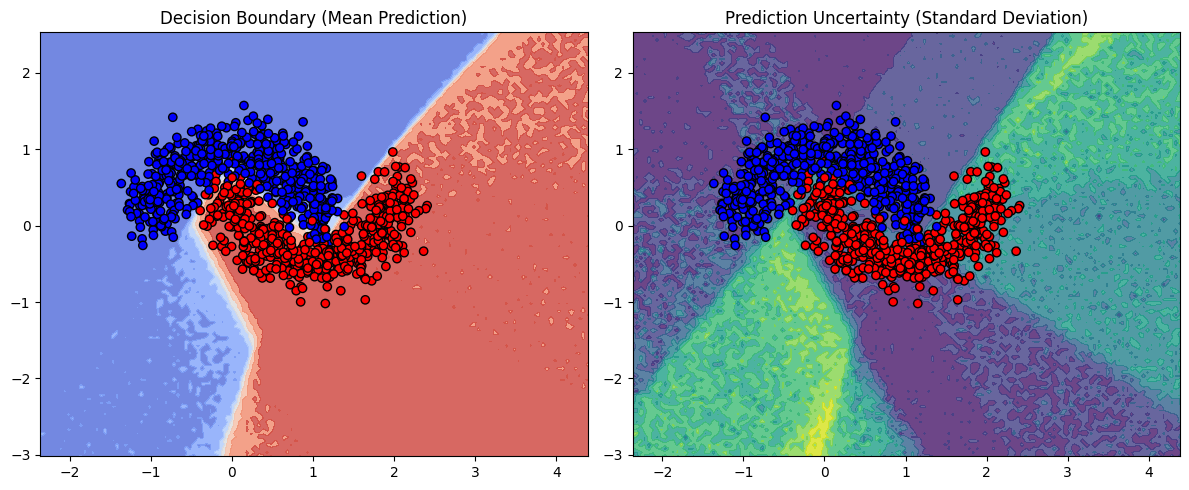

In [ ]:
class MCDropoutNN(nn.Module):
    def __init__(self, features, dropout_rate=0.1):
        super(MCDropoutNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(p=dropout_rate))
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return self.sigmoid(X)

    def loss_fn(self, X, y):
        y_pred = self.forward(X)
        return F.binary_cross_entropy(y_pred, y)

    @torch.no_grad()
    def predict(self, X_test, y_test=None, num_samples=100, batch_size=None, device=torch.device('cpu')):
        test_dataset = TensorDataset(X_test, y_test) if y_test is not None else TensorDataset(X_test)
        batch_size = len(test_dataset) if batch_size is None else batch_size
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.to(device)
        self.train()  # Set to train mode to enable dropout

        if y_test is not None:
            all_preds = []
            for _ in range(num_samples):
                preds = []
                for x, y in test_dataloader:
                    x, y = x.to(device), y.to(device)
                    y_pred = self.forward(x)
                    preds.append(y_pred)
                preds = torch.cat(preds, dim=0)
                all_preds.append(preds)

            all_preds = torch.stack(all_preds)
            mean_preds = all_preds.mean(dim=0)
            y_pred = (mean_preds >= 0.5).float()

            wrong = (y_pred - y_test.to(device)).abs().sum().item()
            return 1 - wrong / len(test_dataset)
        else:
            all_preds = []
            for _ in range(num_samples):
                preds = []
                for x in test_dataloader:
                    x = x[0].to(device)
                    y_pred = self.forward(x)
                    preds.append(y_pred)
                preds = torch.cat(preds, dim=0)
                all_preds.append(preds)

            all_preds = torch.stack(all_preds)
            mean_preds = all_preds.mean(dim=0)
            std_preds = all_preds.std(dim=0)
            return mean_preds.cpu(), std_preds.cpu()

def train(model, X, y, batch_size=32, lr=0.01, epochs=10, print_iters=50, device=torch.device('cpu')):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    model.to(device)

    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = model.loss_fn(inputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if (epoch + 1) % print_iters == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, losses

# Usage example
# features = [2, 8, 16, 16, 8, 1]
features = [2, 8, 16, 1]
mc_dropout_nn = MCDropoutNN(features, dropout_rate=0.1)

# Train the model
mc_dropout_nn, loss_list = train(mc_dropout_nn, X_train, y_train, batch_size=500, lr=0.01, epochs=1000, device=device)

# Evaluate on test data
accuracy = mc_dropout_nn.predict(X_test, y_test, num_samples=100, device=device)
print(f"The accuracy on the test data is {accuracy * 100:.2f}%")

# Predict on grid with uncertainty
inputs = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)
mean_preds, std_preds = mc_dropout_nn.predict(inputs, num_samples=100, device=device)
mean_preds = mean_preds.reshape(xx.shape)
std_preds = std_preds.reshape(xx.shape)

# Plot decision boundary with uncertainty
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.contourf(xx, yy, mean_preds, cmap='coolwarm', alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='bwr', edgecolors='black')
plt.title('Decision Boundary (Mean Prediction)')

plt.subplot(122)
plt.contourf(xx, yy, std_preds, cmap='viridis', alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='bwr', edgecolors='black')
plt.title('Prediction Uncertainty (Standard Deviation)')

plt.tight_layout()
plt.show()

#### Impacts on Uncertainty

Which of our previous modelling decisions have an impact on our uncertainty estimation?

Try the following:

1. Change the dropout rate
2. Change the training data size
3. Change number of epochs

In [ ]:
#Your code here

# Bayesian Neural Networks

## What are Bayesian Neural Networks?

Unlike traditional neural networks, which provide point estimates of their parameters (weights and biases), BNNs treat these parameters as probability distributions. This Bayesian approach allows for a principled way of understanding model uncertainty, which is crucial in many real-world applications where the reliability of a model's predictions is as important as the predictions themselves.

## Key Concepts

To understand BNNs, it's essential to grasp a few key concepts:

1. **Probability Distributions over Weights**: In a BNN, each weight is represented not by a single value, but by a probability distribution (often a Gaussian distribution). This distribution captures our uncertainty about the "true" value of the weight.

2. **Prior Distributions**: Before seeing any data, we specify our initial beliefs about the weights through prior distributions. These priors encode our assumptions about the model parameters.

3. **Posterior Distributions**: After observing data, we update our beliefs about the weights. The resulting distributions are called posterior distributions, representing our updated knowledge about the model parameters.

4. **Bayesian Inference**: The process of updating our beliefs (moving from prior to posterior) is done through Bayesian inference, typically using Bayes' theorem.

5. **Prediction Uncertainty**: When making predictions with a BNN, we can propagate the uncertainty in the weights to get a distribution over possible outputs, rather than a single point estimate.

## Advantages of Bayesian Neural Networks

BNNs offer several advantages over traditional neural networks:

1. **Uncertainty Quantification**: BNNs provide a principled way to estimate the uncertainty in predictions, which is crucial in decision-making processes.

2. **Regularization**: The Bayesian approach naturally guards against overfitting by integrating over all possible parameter values.

3. **Robustness to Overfitting**: BNNs are less prone to overfitting, especially when dealing with small datasets.

4. **Handling Small Data**: BNNs can perform well even with limited data, as they can incorporate prior knowledge and quantify uncertainty.

5. **Model Comparison**: Bayesian methods provide natural ways to compare different models through techniques like Bayesian model averaging.

## Challenges in Bayesian Neural Networks


Despite their advantages, BNNs come with their own set of challenges:

1. **Computational Complexity**: Exact Bayesian inference is often intractable for neural networks, necessitating the use of approximation techniques.

2. **Scalability**: Many Bayesian inference techniques struggle with large datasets and complex network architectures.

3. **Choice of Priors**: Selecting appropriate prior distributions can be challenging and can significantly impact the model's performance.

### Construct a Bayesian linear layer


We start with defining our Bayesian linear layer - a necessary step and one we did not have to do for our traditional NN.

In [ ]:
class BayesianLinear(nn.Module):
    def __init__(
            self, in_features, out_features,
            prior_weight_std=0.1, prior_bias_std=0.1, lecun_init=False
    ):
        super(BayesianLinear, self).__init__()

        # Define the prior params
        prior_mean = 0.
        if lecun_init:  # LeCun initialization：prior variance scales as 1/dim_in
            prior_weight_std /= in_features ** 0.5
            prior_bias_std /= in_features ** 0.5
        # Prior parameters registered as constants
        self.register_buffer('prior_weight_mean', torch.full([out_features, in_features], prior_mean))
        self.register_buffer('prior_weight_std', torch.full([out_features, in_features], prior_weight_std))
        self.register_buffer('prior_bias_mean', torch.full([out_features], prior_mean))
        self.register_buffer('prior_bias_std', torch.full([out_features], prior_bias_std))

    def prior_forward(self, x, num_samples=1):
        # Sample weights and biases from prior normal distributions using re-parameterization trick
        prior_weight = self.prior_weight_mean + self.prior_weight_std * torch.randn(num_samples, *self.prior_weight_std.shape)
        prior_bias = self.prior_bias_mean + self.prior_bias_std * torch.randn(num_samples, *self.prior_bias_std.shape)
        return x @ prior_weight.mT + prior_bias.unsqueeze(-2)

### The BNN Model

With our new Bayesian linear layer, we are free to now define our BNN model.

In [ ]:
class BayesianNN(nn.Module):
    def __init__(self, features, **layer_prior_kwargs):
        super(BayesianNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(BayesianLinear(features[i], features[i+1], **layer_prior_kwargs))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    @torch.no_grad()
    def prior_forward(self, x, num_samples=1):
        for layer in self.layers:
            if isinstance(layer, BayesianLinear):
                x = layer.prior_forward(x, num_samples)
            else:
                x = layer(x)
        return self.sigmoid(x)

### Random functions from the prior

We can now sample the prior random functions output by the BNN to see the effects of changing the prior hyperparameters. Try changing it yourself to see the impacts below!

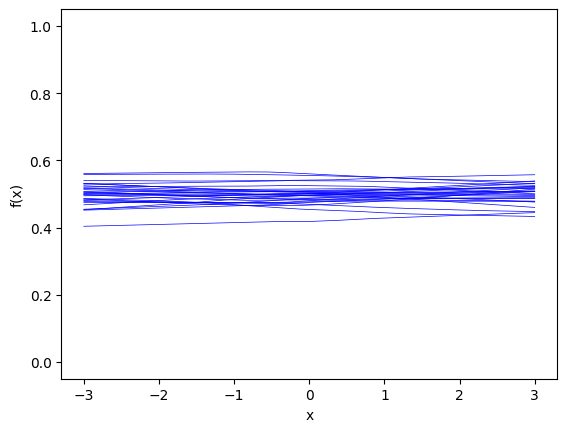

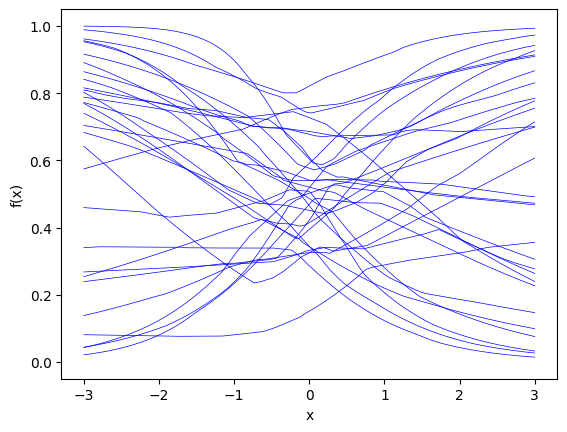

In [ ]:
def plot_prior_samples(model, x, num_samples):
    prior_samples = model.prior_forward(x, num_samples)
    plt.plot(x.squeeze(-1).numpy(), prior_samples.squeeze(-1).mT.numpy(), 'b', linewidth=0.5)

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.ylim(-0.05, 1.05)
    plt.show()


# Construct a 2-layer BNN
features = [1, 20, 1]
BNN = BayesianNN(features, prior_weight_std=0.1, prior_bias_std=0.1, lecun_init=False)

# Plot random prior samples
num_samples = 30
x = torch.linspace(-3, 3, 300).view(-1, 1)
plot_prior_samples(BNN, x, num_samples)

# We can change the prior to see its effect on the output functions
BNN_changed_prior = BayesianNN(features, prior_weight_std=1., prior_bias_std=1., lecun_init=True)
plot_prior_samples(BNN_changed_prior, x, num_samples)

## Inference - Posterior Approximation

Exact Bayesian inference is typically intractable for neural networks due to the high dimensionality of the parameter space. We can use something called 'mean-field variational inference' (MFVI, also known as [Bayes-by-backprop](https://arxiv.org/abs/1505.05424)) to approximate the posterior distributions of the BNN parameters.

### Mean-field Variational Inference (MFVI)

#### The Basics of Variational Inference

Variational inference, in general, aims to approximate a complex posterior distribution $P(w|D)$ with a simpler distribution $Q(w|\theta)$, where $w$ represents the model parameters (weights in a neural network), $D$ is the observed data, and $\theta$ are the parameters of the approximating distribution.

The goal is to minimize the Kullback-Leibler (KL) divergence between the approximate posterior $Q(w|\theta)$ and the true posterior $P(w|D)$:

$$\text{KL}[Q(w|\theta) || P(w|D)]$$

This is equivalent to maximizing the Evidence Lower Bound (ELBO):

$$\text{ELBO} = \mathbb{E}[\log P(D|w)] - \text{KL}[Q(w|\theta) || P(\theta)]$$

Where $P(w)$ is the prior distribution over the weights.

#### Mean-Field Approximation

The "mean-field" part of MFVI comes from the assumption that the approximating distribution $Q$ can be factorized into independent distributions over each parameter:

$$Q(w|\theta) = \prod_i Q(w_i|\theta_i)$$

This assumption significantly simplifies the optimization problem and makes the inference computationally tractable, especially for high-dimensional problems like neural networks.

#### Application to Bayesian Neural Networks

In the context of Bayesian Neural Networks, as described in the paper "Weight Uncertainty in Neural Networks" by Blundell et al., MFVI is used as follows:

1. **Variational Posterior**: Each weight in the network is assigned a probability distribution (typically Gaussian) instead of a point estimate. The parameters of these distributions (mean and variance) become the learnable parameters of the network.

2. **Prior**: A prior distribution is placed over the weights. The paper uses a scale mixture of two Gaussian distributions as the prior, which allows for both sparsity and regularization.

3. **Objective Function**: The training objective becomes the variational free energy, which is equivalent to the negative ELBO:

   $$F(D, \theta) = \text{KL}[Q(w|\theta) || P(w)] - \mathbb{E}[\log P(D|w)]$$

   This objective balances between fitting the data (the likelihood term) and keeping the approximate posterior close to the prior (the KL divergence term).

4. **Optimization**: The objective is optimized using gradient descent. The gradients are estimated using the "reparameterization trick", which allows backpropagation through the random sampling process.

5. **Inference**: During inference, weight samples are drawn from the learned posterior distributions, effectively creating an ensemble of networks. This allows for uncertainty estimation in the predictions.

We show the implementation of MFVI to our BNN below:

In [ ]:
class MFVIBayesianLinear(BayesianLinear):  # Inherit
    def __init__(
            self, in_features, out_features,
            init_std=0.1, **layer_prior_kwargs
    ):
        super(MFVIBayesianLinear, self).__init__(in_features, out_features, **layer_prior_kwargs)

        # Mean and log variance for weights and biases of variational distributions
        self.weight_mean = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_logstd = nn.Parameter(torch.ones(out_features, in_features))
        self.bias_mean = nn.Parameter(torch.zeros(out_features))
        self.bias_logstd = nn.Parameter(torch.ones(out_features))

        # initialization
        self.reset_params(in_features, init_std)

    def reset_params(self, in_features, init_std):
        # initialization
        nn.init.kaiming_uniform_(self.weight_mean)
        bound = 1 / in_features ** 0.5
        nn.init.uniform_(self.bias_mean, -bound, bound)
        nn.init.constant_(self.weight_logstd, math.log(init_std + EPS))
        nn.init.constant_(self.bias_logstd, math.log(init_std + EPS))

    @property
    def weight_std(self):
        return torch.exp(self.weight_logstd)

    @property
    def bias_std(self):
        return torch.exp(self.bias_logstd)

    def forward(self, x, num_samples=1):  # Sample weights and biases from normal distributions
        weight = Normal(self.weight_mean, self.weight_std).rsample([num_samples])
        bias = Normal(self.bias_mean, self.bias_std).rsample([num_samples])
        return x @ weight.mT + bias.unsqueeze(-2)

    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q_weight = Normal(self.weight_mean, self.weight_std)
        p_weight = Normal(self.prior_weight_mean, self.prior_weight_std)
        q_bias = Normal(self.bias_mean, self.bias_std)
        p_bias = Normal(self.prior_bias_mean, self.prior_bias_std)
        return kl.kl_divergence(q_weight, p_weight).sum() + kl.kl_divergence(q_bias, p_bias).sum()


In [ ]:
class MFVIBayesianNN(nn.Module):
    def __init__(self, features, init_std=0.1, **layer_prior_kwargs):
        super(MFVIBayesianNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(MFVIBayesianLinear(
                features[i], features[i+1], init_std, **layer_prior_kwargs)
            )
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, num_samples=1):
        for layer in self.layers:
            x = layer(x, num_samples) if isinstance(layer, MFVIBayesianLinear) else layer(x)
        return self.sigmoid(x)

    def expected_log_prob(self, X, y, num_samples=1):
        y_pred = self.forward(X, num_samples).mean(dim=0)
        loss = F.binary_cross_entropy(y_pred, y, reduction='mean')
        return - loss

    # collect the kl divergence for all MFVILinear layers
    def kl_divergence(self):
        kl = 0.
        for layer in self.layers:
            if isinstance(layer, MFVIBayesianLinear):
                kl = kl + layer.kl_divergence()
        return kl

    def loss_fn(self, X, y, num_data, num_samples=1, tempered=1.):  # `tempered` is the coefficient of the KL term
        data_fit = self.expected_log_prob(X, y, num_samples)
        kl = self.kl_divergence() * tempered / num_data
        return - (data_fit - kl)

    @torch.no_grad()
    def predict(
            self, X_test, y_test=None, num_samples=1,
            batch_size=None, device=torch.device('cpu')
    ):
        test_dataset = TensorDataset(X_test, y_test) if y_test is not None else TensorDataset(X_test)
        batch_size = len(test_dataset) if batch_size is None else batch_size
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.to(device)
        if y_test is not None:
            preds = []
            for x, y in test_dataloader:
                x, y, y_test = x.to(device), y.to(device), y_test.to(device)
                y_pred = self.forward(x, num_samples).mean(dim=0)
                preds.append(y_pred)
            preds = torch.cat(preds, dim=-2)
            y_pred = (preds >= 0.5).to(torch.get_default_dtype())
            wrong = (y_pred - y_test).abs().sum().item()
            return 1 - wrong / len(test_dataset)

        else:
            preds = []
            for x in test_dataloader:
                x = x[0].to(device)
                y_pred = self.forward(x, num_samples).mean(dim=0)
                preds.append(y_pred)
            preds = torch.cat(preds, dim=-2)
            return preds.to(torch.device('cpu'))

In [ ]:
# Construct a BNN with the same structure
# features = [2, 8, 16, 16, 8, 1]
features = [2, 8, 16, 1]
init_std = 0.01
layer_prior_kwargs = {
    'prior_weight_std': 1.,
    'prior_bias_std': 1.,
    'lecun_init': True
}
bnn = MFVIBayesianNN(features, init_std, **layer_prior_kwargs)

bnn

MFVIBayesianNN(
  (layers): ModuleList(
    (0): MFVIBayesianLinear()
    (1): ReLU()
    (2): MFVIBayesianLinear()
    (3): ReLU()
    (4): MFVIBayesianLinear()
  )
  (sigmoid): Sigmoid()
)

#### Train BNN

We now train the given BNN model using the same training regime as for our traditional neural network.

Epoch [100/1500], Loss: 0.8425
Epoch [200/1500], Loss: 0.5632
Epoch [300/1500], Loss: 0.3779
Epoch [400/1500], Loss: 0.3343
Epoch [500/1500], Loss: 0.3155
Epoch [600/1500], Loss: 0.3150
Epoch [700/1500], Loss: 0.3133
Epoch [800/1500], Loss: 0.2935
Epoch [900/1500], Loss: 0.3038
Epoch [1000/1500], Loss: 0.2980
Epoch [1100/1500], Loss: 0.3003
Epoch [1200/1500], Loss: 0.3022
Epoch [1300/1500], Loss: 0.2986
Epoch [1400/1500], Loss: 0.2914
Epoch [1500/1500], Loss: 0.3161


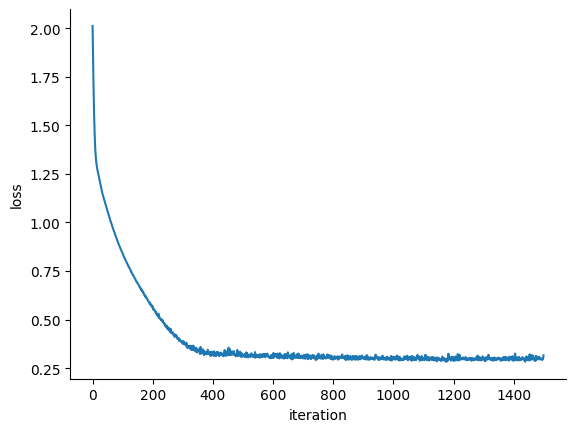

In [ ]:
def train(
        model, X, y, batch_size=32, lr=0.01, num_samples=100, tempered=1.,
        epochs=10, print_iters=50, device=torch.device('cpu')
):
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoader for batching
    dataset = TensorDataset(X, y)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()  # Set model to training mode
    model.to(device)

    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()                 # Zero the gradient
            loss = model.loss_fn(
                inputs, labels, num_data=len(dataset),
                num_samples=num_samples, tempered=tempered
            )                                     # Loss function (CrossEntropyLoss in this case)
            loss.backward()                       # Backpropagation
            optimizer.step()                      # Update weights
            losses.append(loss.item())

        if (epoch + 1) % print_iters == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, losses

# Train the BNN
bnn, loss_list = train(
    bnn, X_train, y_train,
    batch_size=y_train.size(-2), lr=0.01, num_samples=10, tempered=1,
    epochs=1500, print_iters=100, device=device
)

plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
sns.despine()

The accuracy on the test data is 94.80%


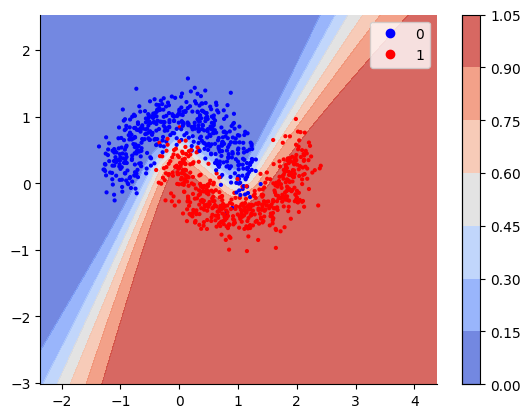

In [ ]:
# Predict on test data
bnn.eval()
acc = bnn.predict(X_test, y_test, num_samples=100, device=device)

print(f"The accuracy on the test data is {acc * 100:.2f}%")

# Predict on grid
inputs = np.stack([xx.ravel(), yy.ravel()], axis=-1)
p = bnn.predict(torch.as_tensor(inputs, dtype=torch.get_default_dtype()),
                num_samples=100, device=device)
p = p.reshape(xx.shape)

plot_binary_class(X, Y, xx, yy, p, legend=True, color_bar=True)

### How does our BNN compare with our NN?

We now want you to perform a series of comparisons between the BNN implementation and the conventional NN. Look at in particular:

1. How does the loss graph differ?
2. Can you attain the same performance as the NN using a BNN with a smaller network structure (fewer hidden layers, less nodes)?
3. What is the difference in time to run and train our models?

From these experiments, discuss and conclude what situations you might find yourself wanting to use a BNN over a NN.

In [ ]:
#Your code here!

### Last-layer BNN with full-rank Gaussian approximation

While Gaussian distributions with full-rank covariance matrices are more expressive than the factorised Gaussians in the above MFVI, it requires much more variational parameters. Instead of using full covariance Gaussians at all layers, we use deterministic network layers for all but the last layer, and use a full-rank Gaussian approximation for the last layer.

The corresponding ELBO becomes

$$\text{ELBO}=\mathbb{E}[\log p(D\mid\theta)]-\text{KL}[q(\theta^L)\mid\mid p(\theta^L)],$$
where we only compute the KL for the last layer.

In the following cell, we define a BNN layer with a full-rank Gaussian as the variational distribution. We parameterise the Cholesky factor of the covariance matrix.

In [ ]:
class FullCovGaussianLinear(BayesianLinear):
    def __init__(
            self, in_features, out_features,
            init_std=0.1, **layer_prior_kwargs
    ):
        super(FullCovGaussianLinear, self).__init__(in_features, out_features, **layer_prior_kwargs)
        self.in_features, self.out_features = in_features, out_features

        # Mean for weights and biases of variational distributions
        self.weight_mean = nn.Parameter(torch.zeros(out_features, in_features))
        self.bias_mean = nn.Parameter(torch.zeros(out_features))

        # Parameterise the covariance matrix by Cholesky factor
        num_params = in_features * out_features + out_features
        self._cov_diag = nn.Parameter(torch.zeros(num_params))  # raw parameters
        self._cov_tril = nn.Parameter(torch.zeros(num_params, num_params))

        # initialisation
        self.reset_params(in_features, init_std)

    def reset_params(self, in_features, init_std):
        # initialise mean
        nn.init.kaiming_uniform_(self.weight_mean)
        bound = 1 / in_features ** 0.5
        nn.init.uniform_(self.bias_mean, -bound, bound)

        # initialise covariance
        _init_std_param = math.log(math.expm1(init_std))
        self._cov_diag.data = torch.full_like(self._cov_diag.data, _init_std_param)
        self._cov_tril.data = torch.full_like(self._cov_tril.data, 0.0)

    @property
    def mean(self):
        return torch.concat((self.weight_mean.flatten(), self.bias_mean.flatten()))

    @property
    def cholesky_factor(self):
        # return the cholesky decomposition L of the covariance: Cov = LL^T
        return F.softplus(self._cov_diag).diag_embed() + torch.tril(self._cov_tril, diagonal=-1)

    @property
    def variational_distribution(self):
        return MultivariateNormal(self.mean, scale_tril=self.cholesky_factor)

    @property
    def prior_distribution(self):
        prior_mean = torch.cat([self.prior_weight_mean.flatten(), self.prior_bias_mean.flatten()])
        prior_std_diag = torch.concat([self.prior_weight_std.flatten(), self.prior_bias_std.flatten()])
        prior_scale_tril = prior_std_diag.diag_embed()
        return MultivariateNormal(prior_mean, scale_tril=prior_scale_tril)

    def forward(self, x, num_samples=1):
        q = self.variational_distribution
        samples = q.rsample([num_samples])

        weight_samples = samples[:, :self.in_features * self.out_features]
        weights = weight_samples.reshape(num_samples, self.out_features, self.in_features)
        bias = samples[:, self.in_features * self.out_features:]
        return x @ weights.mT + bias.unsqueeze(-2)

    def kl_divergence(self):
        q = self.variational_distribution
        p = self.prior_distribution
        return kl.kl_divergence(q, p)

Now we can build a BNN whose last layer has a full-rank Gaussian variational distribution.

In [ ]:
class LastLayerFullCovBayesianNN(MFVIBayesianNN):
    def __init__(self, features, init_std=0.1, **layer_prior_kwargs):
        super(MFVIBayesianNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            if i < len(features) - 2:
                self.layers.append(nn.Linear(features[i], features[i+1]))
                self.layers.append(nn.ReLU())
            else:  # the last layer
                self.layers.append(FullCovGaussianLinear(features[i], features[i+1], init_std, **layer_prior_kwargs))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, num_samples=1):
        for layer in self.layers:
            x = layer(x, num_samples) if isinstance(layer, FullCovGaussianLinear) else layer(x)
        return self.sigmoid(x)

    def kl_divergence(self):  # we only compute the last layer's KL
        return self.layers[-1].kl_divergence()

# Construct a BNN with the same structure
# features = [2, 8, 16, 16, 8, 1]
features = [2, 8, 16, 1]
init_std = 1.
layer_prior_kwargs = {
    'prior_weight_std': 1.,
    'prior_bias_std': 1.,
    'lecun_init': False
}
bnn_last_layer = LastLayerFullCovBayesianNN(features, init_std, **layer_prior_kwargs)

bnn_last_layer

LastLayerFullCovBayesianNN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): FullCovGaussianLinear()
  )
  (sigmoid): Sigmoid()
)

Epoch [100/1000], Loss: 0.1675
Epoch [200/1000], Loss: 0.0858
Epoch [300/1000], Loss: 0.0761
Epoch [400/1000], Loss: 0.0731
Epoch [500/1000], Loss: 0.0699
Epoch [600/1000], Loss: 0.0682
Epoch [700/1000], Loss: 0.0683
Epoch [800/1000], Loss: 0.0672
Epoch [900/1000], Loss: 0.0654
Epoch [1000/1000], Loss: 0.0651


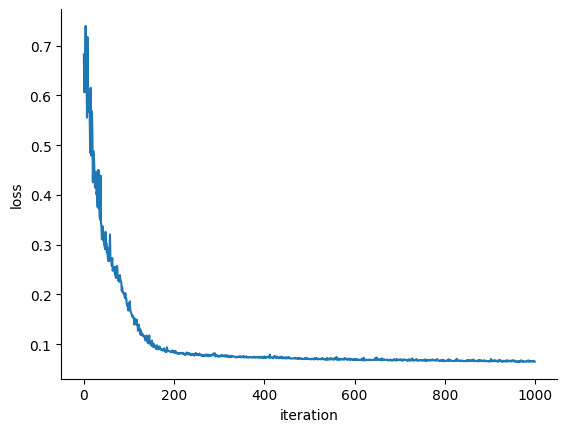

In [ ]:
# Train the BNN
bnn_last_layer, loss_list = train(
    bnn_last_layer, X_train, y_train,
    batch_size=y_train.size(-2), lr=0.01, num_samples=10, tempered=1,
    epochs=1000, print_iters=100, device=device
)

plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
sns.despine()

The accuracy on the test data is 96.00%


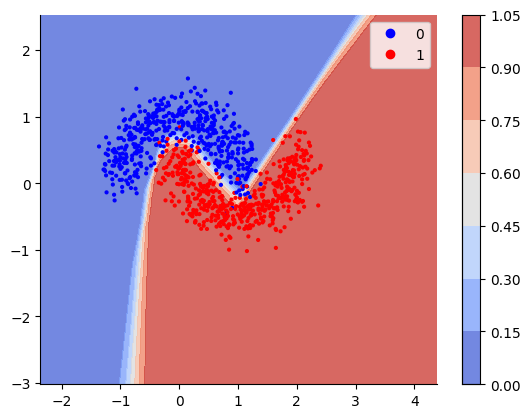

In [ ]:
# Predict on test data
bnn_last_layer.eval()
acc = bnn_last_layer.predict(X_test, y_test, num_samples=100, device=device)

print(f"The accuracy on the test data is {acc * 100:.2f}%")

# Predict on grid
inputs = np.stack([xx.ravel(), yy.ravel()], axis=-1)
p = bnn_last_layer.predict(torch.as_tensor(inputs, dtype=torch.get_default_dtype()),
                           num_samples=100, device=device)
p = p.reshape(xx.shape)

plot_binary_class(X, Y, xx, yy, p, legend=True, color_bar=True)

### Final bonus exercise

Above we showed an implementation for a Bayesian last layer NN. The ability to use this as a trade off between the merits and deficits of both NN and BNN's is obvious. Could you take the above code and add multiple Bayesian layers to create a more complex hybrid model? You may want to read an [original implementation paper](https://arxiv.org/pdf/2404.11599).

1. Implement a hybrid model with more than just a Bayesian last layer.
2. What changes might you need to make as the number of Bayesian layers increase?
3. Is there even a benefit to doing this? Where does that benefit start/ end?

In [ ]:
#Your code here

Github used as references
   1. https://github.com/probml/pyprobml/blob/master/notebooks/book2/17/makemoons_comparison.ipynb

   2. https://github.com/probabilisticai/probai-2023/tree/main/day_4/1_yingzhenli
    
   3. Monte Carlo Dropout: https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/#5-dropout-as-bayesian-approximation

# Bonus Exercise: Hamiltonian Monte Carlo (HMC)

Hamiltonian Monte Carlo (HMC) is a Markov Chain Monte Carlo (MCMC) method ([explored by Neal in this chapter](https://arxiv.org/pdf/1206.1901)) that is particularly effective for sampling from high-dimensional probability distributions. It's widely used in Bayesian statistics and machine learning, including for sampling from the posterior distributions of Bayesian neural networks.

HMC combines concepts from Hamiltonian dynamics in physics with traditional MCMC methods. For a brief overview:

- State Space: HMC operates in an extended state space that includes:

   Position variables (q): These correspond to the parameters we're interested in sampling.
   Momentum variables (p): These are auxiliary variables introduced to enable the Hamiltonian dynamics.


- Hamiltonian Function: We define a Hamiltonian function H(q, p) that consists of two parts:

   Potential energy U(q): This is related to the negative log probability of the target distribution.
   Kinetic energy K(p): This is typically defined as a quadratic function of the momentum variables.

- Leapfrog Integration: HMC uses a numerical integration method called leapfrog integration to simulate the Hamiltonian dynamics. This process proposes new states in the Markov chain.

- Metropolis Acceptance Step: After the leapfrog integration, an acceptance step is performed to ensure that the chain converges to the correct target distribution.

### Exercise: Implement HMC For Sampling From a Multivariate Normal Distribution

Implement a simple HMC sampler to sample from a 2D Gaussian distribution. Compare its performance with a standard Metropolis-Hastings algorithm. Can you expand this to be used in a BNN? [You may use online resources to help.](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/)

In [ ]:
#Your code here

# Bonus Exercise: Infinitely Wide Neural Networks

An interesting phenomenon is found when we consider what happens when a neural network has an infinitely wide single layer. What we end up seeing is that the NN converges to a Gaussian Process- [this is also the case for certain deep neural network architectures too](https://arxiv.org/pdf/1711.00165).

As the width of a neural network approaches infinity:

1. The pre-activation outputs of the network converge to a multivariate Gaussian distribution.
2. The covariance between any two outputs becomes independent of the specific weight values and depends only on the network architecture and activation functions.
3. This limiting distribution can be described exactly by a Gaussian Process.

The immediate benefits of doing this are similar to using a BNN- more concrete uncertainty quantification and potentially improved model performance.

What you are being asked to do here is to evaluate how increasing the width of a single layer NN impacts performance. Keep stretching the size and evaluating. When you get a good idea of how this model is being changed, try to use [JAX and the Neural Tangents library](https://towardsdatascience.com/infinitely-wide-neural-networks-neural-tangents-explained-d6c6d896fcbf) to implement an infinitely wide NN. You should also consider how this relates to a BNN- what happens if you do the same with a BNN? Does it make sense to do this?

In [ ]:
#Your code here